In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
with open('txt_files/semantic_chunk_example.txt') as file:
    text = file.read()
print(text)

Hello, Welcome to GenAI Lunch & Learn Series.  Isn’t it exciting to Lunch & Learn ? Next Friday we have AI COE Special Event. Don’t miss it ! This is text is to just demonstrate Semantic Chunking. 


In [3]:
import re

# Splitting the essay on '.', '?', and '!'
single_sentences_list = re.split(r'(?<=[.?!])\s+', text)
print (f"{len(single_sentences_list)} senteneces were found")

6 senteneces were found


In [4]:
print(single_sentences_list)

['Hello, Welcome to GenAI Lunch & Learn Series.', 'Isn’t it exciting to Lunch & Learn ?', 'Next Friday we have AI COE Special Event.', 'Don’t miss it !', 'This is text is to just demonstrate Semantic Chunking.', '']


In [5]:
sentences = [{'sentence': x, 'index' : i} for i, x in enumerate(single_sentences_list)]
sentences[:5]

[{'sentence': 'Hello, Welcome to GenAI Lunch & Learn Series.', 'index': 0},
 {'sentence': 'Isn’t it exciting to Lunch & Learn ?', 'index': 1},
 {'sentence': 'Next Friday we have AI COE Special Event.', 'index': 2},
 {'sentence': 'Don’t miss it !', 'index': 3},
 {'sentence': 'This is text is to just demonstrate Semantic Chunking.',
  'index': 4}]

In [6]:
def combine_sentences(sentences, buffer_size=1):
    # Go through each sentence dict
    for i in range(len(sentences)):

        # Create a string that will hold the sentences which are joined
        combined_sentence = ''

        # Add sentences before the current one, based on the buffer size.
        for j in range(i - buffer_size, i):
            # Check if the index j is not negative (to avoid index out of range like on the first one)
            if j >= 0:
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += sentences[j]['sentence'] + ' '

        # Add the current sentence
        combined_sentence += sentences[i]['sentence']

        # Add sentences after the current one, based on the buffer size
        for j in range(i + 1, i + 1 + buffer_size):
            # Check if the index j is within the range of the sentences list
            if j < len(sentences):
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += ' ' + sentences[j]['sentence']
                
        # Then add the whole thing to your dict
        # Store the combined sentence in the current sentence dict
        sentences[i]['combined_sentence'] = combined_sentence

    return sentences


In [7]:
sentences = combine_sentences(sentences)

print(sentences)

[{'sentence': 'Hello, Welcome to GenAI Lunch & Learn Series.', 'index': 0, 'combined_sentence': 'Hello, Welcome to GenAI Lunch & Learn Series. Isn’t it exciting to Lunch & Learn ?'}, {'sentence': 'Isn’t it exciting to Lunch & Learn ?', 'index': 1, 'combined_sentence': 'Hello, Welcome to GenAI Lunch & Learn Series. Isn’t it exciting to Lunch & Learn ? Next Friday we have AI COE Special Event.'}, {'sentence': 'Next Friday we have AI COE Special Event.', 'index': 2, 'combined_sentence': 'Isn’t it exciting to Lunch & Learn ? Next Friday we have AI COE Special Event. Don’t miss it !'}, {'sentence': 'Don’t miss it !', 'index': 3, 'combined_sentence': 'Next Friday we have AI COE Special Event. Don’t miss it ! This is text is to just demonstrate Semantic Chunking.'}, {'sentence': 'This is text is to just demonstrate Semantic Chunking.', 'index': 4, 'combined_sentence': 'Don’t miss it ! This is text is to just demonstrate Semantic Chunking. '}, {'sentence': '', 'index': 5, 'combined_sentence': 

In [17]:
from langchain.embeddings import OpenAIEmbeddings
oaiembeds = OpenAIEmbeddings()
embeddings = oaiembeds.embed_documents([x['combined_sentence'] for x in sentences])


In [9]:
for i, sentence in enumerate(sentences):
    sentence['combined_sentence_embedding'] = embeddings[i]

In [10]:
from sklearn.metrics.pairwise import cosine_similarity

def calculate_cosine_distances(sentences):
    distances = []
    for i in range(len(sentences) - 1):
        embedding_current = sentences[i]['combined_sentence_embedding']
        embedding_next = sentences[i + 1]['combined_sentence_embedding']
        
        # Calculate cosine similarity
        similarity = cosine_similarity([embedding_current], [embedding_next])[0][0]
        
        # Convert to cosine distance
        distance = 1 - similarity

        # Append cosine distance to the list
        distances.append(distance)

        # Store distance in the dictionary
        sentences[i]['distance_to_next'] = distance

    # Optionally handle the last sentence
    # sentences[-1]['distance_to_next'] = None  # or a default value

    return distances, sentences

In [11]:
distances, sentences = calculate_cosine_distances(sentences)

In [18]:
print(len(sentences))
print(len(distances))
print(distances)

6
5
[0.05365165370675218, 0.039443675313970306, 0.09030306934420063, 0.09121382612843709, 0.04556532746311581]


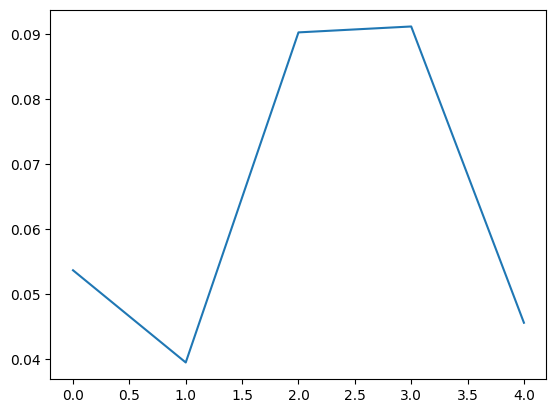

In [13]:
import matplotlib.pyplot as plt

plt.plot(distances);

0.0910316747715898
[3]


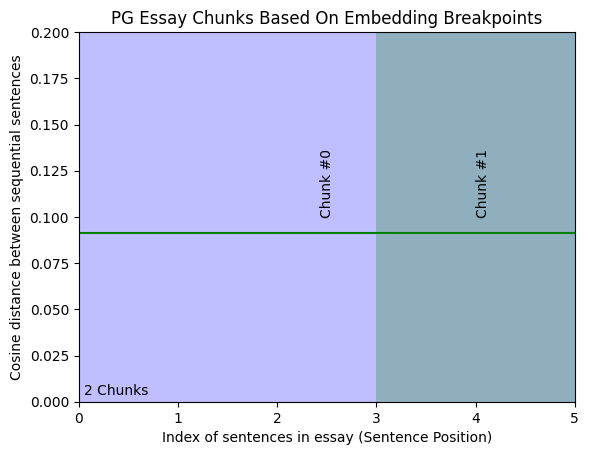

In [14]:
import numpy as np
y_upper_bound = .2
plt.ylim(0, y_upper_bound)
plt.xlim(0, len(distances))
breakpoint_percentile_threshold = 95
breakpoint_distance_threshold = np.percentile(distances, breakpoint_percentile_threshold)
print(breakpoint_distance_threshold)
plt.axhline(y=breakpoint_distance_threshold, color='g', linestyle='-');
num_distances_above_theshold = len([x for x in distances if x > breakpoint_distance_threshold])
# print(num_distances_above_theshold)
plt.text(x=(len(distances)*.01), y=y_upper_bound/50, s=f"{num_distances_above_theshold + 1} Chunks");
indices_above_thresh = [i for i, x in enumerate(distances) if x > breakpoint_distance_threshold] # The indices of those breakpoints on your list
print(indices_above_thresh)
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i, breakpoint_index in enumerate(indices_above_thresh):
    start_index = 0 if i == 0 else indices_above_thresh[i - 1]
    end_index = breakpoint_index if i < len(indices_above_thresh) - 1 else len(distances)

    plt.axvspan(start_index, end_index, facecolor=colors[i % len(colors)], alpha=0.25)
    plt.text(x=np.average([start_index, end_index]),
             y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
             s=f"Chunk #{i}", horizontalalignment='center',
             rotation='vertical')

# # Additional step to shade from the last breakpoint to the end of the dataset
if indices_above_thresh:
    last_breakpoint = indices_above_thresh[-1]
    if last_breakpoint < len(distances):
        plt.axvspan(last_breakpoint, len(distances), facecolor=colors[len(indices_above_thresh) % len(colors)], alpha=0.25)
        plt.text(x=np.average([last_breakpoint, len(distances)]),
                 y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
                 s=f"Chunk #{i+1}",
                 rotation='vertical')

plt.title("PG Essay Chunks Based On Embedding Breakpoints")
plt.xlabel("Index of sentences in essay (Sentence Position)")
plt.ylabel("Cosine distance between sequential sentences")
plt.show()

In [15]:
start_index = 0
chunks = []
for index in indices_above_thresh:
    # The end index is the current breakpoint
    end_index = index

    # Slice the sentence_dicts from the current start index to the end index
    group = sentences[start_index:end_index + 1]
    combined_text = ' '.join([d['sentence'] for d in group])
    print("combined text {}".format(combined_text))
    chunks.append(combined_text)
    start_index = index + 1
# The last group, if any sentences remain
if start_index < len(sentences):
    combined_text = ' '.join([d['sentence'] for d in sentences[start_index:]])
    chunks.append(combined_text)
print(chunks)

combined text Hello, Welcome to GenAI Lunch & Learn Series. Isn’t it exciting to Lunch & Learn ? Next Friday we have AI COE Special Event. Don’t miss it !
['Hello, Welcome to GenAI Lunch & Learn Series. Isn’t it exciting to Lunch & Learn ? Next Friday we have AI COE Special Event. Don’t miss it !', 'This is text is to just demonstrate Semantic Chunking. ']


In [16]:
for i, chunk in enumerate(chunks):
   
    
    print (f"Chunk #{i}")
    print (chunk.strip())
    print ("\n")

Chunk #0
Hello, Welcome to GenAI Lunch & Learn Series. Isn’t it exciting to Lunch & Learn ? Next Friday we have AI COE Special Event. Don’t miss it !


Chunk #1
This is text is to just demonstrate Semantic Chunking.


